In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import spacy

In [32]:
nlp = spacy.load("es_core_news_sm")

In [33]:
def preprocess_text(text):
    doc = nlp(str(text).lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [34]:
train_df = pd.read_csv("imagenes/memes_entrenamiento_etiquetados_02.csv")
val_df = pd.read_csv("imagenes/memes_validacion.csv")

In [35]:
train_df["text_input"] = (train_df["text"] + " " + train_df["description"]).apply(preprocess_text)
val_df["text_input"] = (val_df["text"] + " " + val_df["description"]).apply(preprocess_text)


In [37]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text_input"])

X_train_seq = tokenizer.texts_to_sequences(train_df["text_input"])
X_val_seq = tokenizer.texts_to_sequences(val_df["text_input"])

In [38]:
max_len = 100  # puedes ajustar según el análisis
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [39]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["etiqueta"])

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [41]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
57/57 [==============================] - 6s 52ms/step - loss: 1.2445 - accuracy: 0.6166 - val_loss: 1.1693 - val_accuracy: 0.6115
Epoch 2/10
57/57 [==============================] - 3s 46ms/step - loss: 1.0742 - accuracy: 0.6238 - val_loss: 1.1369 - val_accuracy: 0.6115
Epoch 3/10
57/57 [==============================] - 3s 60ms/step - loss: 0.7928 - accuracy: 0.6989 - val_loss: 1.2758 - val_accuracy: 0.5938
Epoch 4/10
57/57 [==============================] - 2s 43ms/step - loss: 0.4780 - accuracy: 0.8227 - val_loss: 1.5850 - val_accuracy: 0.5651
Epoch 5/10
57/57 [==============================] - 2s 43ms/step - loss: 0.3017 - accuracy: 0.8856 - val_loss: 1.7941 - val_accuracy: 0.5386
Epoch 6/10
57/57 [==============================] - 2s 40ms/step - loss: 0.2216 - accuracy: 0.9088 - val_loss: 2.1934 - val_accuracy: 0.5563
Epoch 7/10
57/57 [==============================] - 2s 39ms/step - loss: 0.1782 - accuracy: 0.9331 - val_loss: 2.8613 - val_accuracy: 0.5342
Epoch 8/10
57

In [42]:
predictions = model.predict(X_val)
pred_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

val_df["etiqueta_predicha"] = pred_labels

# Guardar resultados
val_df.to_csv("imagenes/memes_validacion_etiquetados.csv", index=False)

11/11 [==============================] - 1s 10ms/step


In [43]:
from sklearn.model_selection import train_test_split

# Dividir explícitamente
X_train_final, X_test, y_train_final, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Reentrena el modelo con el nuevo conjunto
model.fit(X_train_final, y_train_final, epochs=10, batch_size=32)

Epoch 1/10
57/57 [==============================] - 2s 39ms/step - loss: 0.4606 - accuracy: 0.8829
Epoch 2/10
57/57 [==============================] - 2s 41ms/step - loss: 0.1748 - accuracy: 0.9547
Epoch 3/10
57/57 [==============================] - 2s 39ms/step - loss: 0.0721 - accuracy: 0.9840
Epoch 4/10
57/57 [==============================] - 2s 36ms/step - loss: 0.0295 - accuracy: 0.9950
Epoch 5/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0169 - accuracy: 0.9950
Epoch 6/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 7/10
57/57 [==============================] - 2s 36ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 8/10
57/57 [==============================] - 2s 35ms/step - loss: 0.0062 - accuracy: 0.9983
Epoch 9/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 10/10
57/57 [==============================] - 2s 38ms/step - loss: 0.0020 - accuracy: 1.0000


15/15 [==============================] - 0s 11ms/step


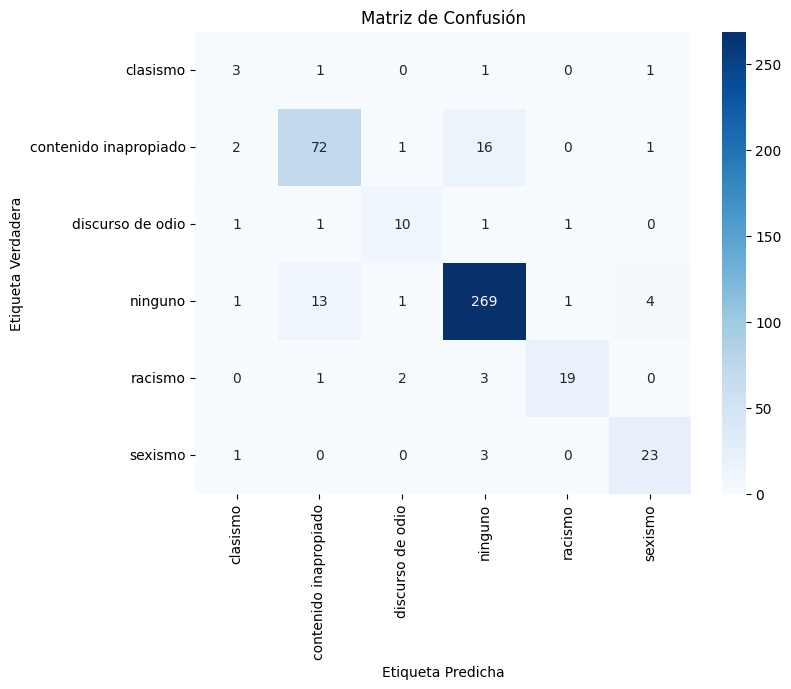

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción en X_test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas legibles
labels = label_encoder.classes_

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión")
plt.show()

In [46]:
def predecir_meme(texto, descripcion):
    entrada = preprocess_text(texto + " " + descripcion)
    secuencia = tokenizer.texts_to_sequences([entrada])
    secuencia_pad = tf.keras.preprocessing.sequence.pad_sequences(secuencia, maxlen=max_len, padding='post')
    pred = model.predict(secuencia_pad)
    etiqueta = label_encoder.inverse_transform([np.argmax(pred)])
    return etiqueta[0]

# Ejemplo
etiqueta = predecir_meme("Las mujeres no sirven para manejar", "Un automovil tras el resultado de un accidente de trafico, con el texto indicando que las mujeres no son aptas para conducir automoviles")
print("Etiqueta predicha:", etiqueta)

1/1 [==============================] - 0s 29ms/step
Etiqueta predicha: clasismo


In [47]:
etiqueta = predecir_meme("tan maricon vas a ser?", "En la imagen aparece Vegitto de Dragon Ball Z, en una pose y un gesto desafiante, señalando al espectador si es un cobarde empleando una expresion dirigida a alguien homosexual")
print("Etiqueta predicha:", etiqueta)

1/1 [==============================] - 0s 145ms/step
Etiqueta predicha: contenido inapropiado
